In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = joblib.load("encoded.pkl")

cost_model = joblib.load("saved_models/cost_model.pkl")
time_model = joblib.load("saved_models/time_model.pkl")

print("✔ Encoded data + ML models loaded!")

✔ Encoded data + ML models loaded!


In [3]:
COST_FEATURES = ['Energy Consumed (kWh)', 'State of Charge (End %)',
                  'Charger Type', 'Energy per 100 km (kWh/100 km)', 
                  'Charging Station Location', 'Vehicle Model', 'Charging Rate (kW)']

TIME_FEATURES =  ['Long Session', 'State of Charge (Start %)', 'Battery Capacity (kWh)', 'State of Charge (End %)', 'Energy Consumed (kWh)']


In [4]:
sample = df.sample(n=5, random_state=42)

X_cost = sample[COST_FEATURES]
X_time = sample[TIME_FEATURES]

cost_pred = float(cost_model.predict(X_cost)[0])
time_pred = float(time_model.predict(X_time)[0])

print("\nMODEL PREDICTIONS:")
print("Cost =", cost_pred)
print("Time =", time_pred)


MODEL PREDICTIONS:
Cost = 12.2072218517
Time = 198.76666666666668


In [5]:
cost = np.arange(0, 61, 1)
time = np.arange(0, 331, 1)
urgent = np.arange(1, 11, 1)
budget = np.arange(1, 11, 1)
comfort = np.arange(0, 101, 1)
strategy = np.arange(0, 3, 1)

In [6]:
cost_low= fuzz.trimf(cost, [0, 0, 25])
cost_med= fuzz.trimf(cost, [15, 30, 45])
cost_high= fuzz.trimf(cost, [35, 60, 60])


time_short= fuzz.trimf(time, [0, 0, 120])
time_med = fuzz.trimf(time, [90, 180, 240])
time_long = fuzz.trimf(time, [200, 330, 330])

urgent_low= fuzz.trimf(urgent, [1, 1, 5])
urgent_med = fuzz.trimf(urgent, [3, 6, 8])
urgent_high = fuzz.trimf(urgent, [7, 10, 10])

budget_low = fuzz.trimf(budget, [1, 1, 5])
budget_med = fuzz.trimf(budget, [3, 6, 8])
budget_high = fuzz.trimf(budget, [7, 10, 10])

comfort_low = fuzz.trimf(comfort, [0, 0, 40])
comfort_med = fuzz.trimf(comfort, [30, 50, 70])
comfort_high = fuzz.trimf(comfort, [60, 100, 100])
strategy_slow = fuzz.trimf(strategy, [0, 0, 1])
strategy_balanced = fuzz.trimf(strategy, [0.5, 1, 1.5])
strategy_fast = fuzz.trimf(strategy, [1.5, 2, 2])

In [7]:
cost_val   = 20
time_val   = 150
urgent_val = 8
budget_val = 7

In [8]:
c_low  = fuzz.interp_membership(cost, cost_low, cost_val)
c_med  = fuzz.interp_membership(cost, cost_med, cost_val)
c_high = fuzz.interp_membership(cost, cost_high, cost_val)

t_short = fuzz.interp_membership(time, time_short, time_val)
t_med   = fuzz.interp_membership(time, time_med, time_val)
t_long  = fuzz.interp_membership(time, time_long, time_val)

u_low  = fuzz.interp_membership(urgent, urgent_low, urgent_val)
u_med  = fuzz.interp_membership(urgent, urgent_med, urgent_val)
u_high = fuzz.interp_membership(urgent, urgent_high, urgent_val)

b_low  = fuzz.interp_membership(budget, budget_low, budget_val)
b_med  = fuzz.interp_membership(budget, budget_med, budget_val)
b_high = fuzz.interp_membership(budget, budget_high, budget_val)

In [9]:
r1 = np.fmin(np.fmin(c_low, t_long), b_low)
r2 = np.fmin(c_low, u_low)
r3 = np.fmin(u_high, b_high)
r4 = np.fmin(c_high, u_high)
r5 = np.fmin(c_med, t_med)
r6 = np.fmin(c_low, t_med)
r7 = np.fmin(c_low, t_short)
r8 = np.fmin(c_med, t_med)
r9 = np.fmax(c_high, t_long)


In [10]:
comfort_high_act = np.fmin(r7, comfort_high)
comfort_med_act  = np.fmin(r8, comfort_med)
comfort_low_act  = np.fmin(r9, comfort_low)

In [11]:
comfort_agg = np.fmax(comfort_low_act,np.fmax(comfort_med_act, comfort_high_act))

In [12]:
comfort_result = fuzz.defuzz(comfort, comfort_agg, 'centroid')


In [13]:
slow_act = np.fmin(np.fmax(r1, r2), strategy_slow)
fast_act = np.fmin(np.fmax(r3, r4), strategy_fast)
bal_act  = np.fmin(np.fmax(r5, r6), strategy_balanced)

In [14]:
strategy_agg = np.fmax(slow_act, np.fmax(fast_act, bal_act))


In [15]:
strategy_result = fuzz.defuzz(strategy, strategy_agg, 'centroid')


In [16]:
cost_val   = cost_pred
time_val   = time_pred
urgent_val = urgent_val
budget_val = budget_val


In [17]:
print("Strategy result:", round(strategy_result, 2))
print("Comfort result:", round(comfort_result, 2))


Strategy result: 1.0
Comfort result: 50.0


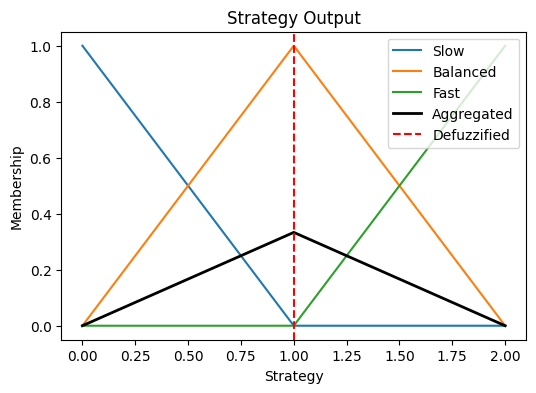

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(strategy, strategy_slow, label='Slow')
plt.plot(strategy, strategy_balanced, label='Balanced')
plt.plot(strategy, strategy_fast, label='Fast')

plt.plot(strategy, strategy_agg, 'k', linewidth=2, label='Aggregated')
plt.axvline(strategy_result, color='r', linestyle='--', label='Defuzzified')

plt.title('Strategy Output')
plt.xlabel('Strategy')
plt.ylabel('Membership')
plt.legend()
plt.show()


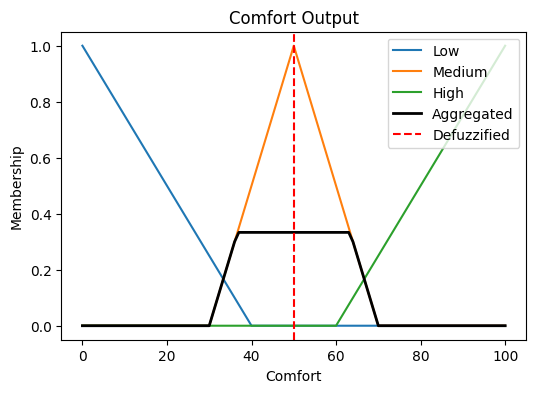

In [21]:
plt.figure(figsize=(6,4))
plt.plot(comfort, comfort_low, label='Low')
plt.plot(comfort, comfort_med, label='Medium')
plt.plot(comfort, comfort_high, label='High')

plt.plot(comfort, comfort_agg, 'k', linewidth=2, label='Aggregated')
plt.axvline(comfort_result, color='r', linestyle='--', label='Defuzzified')

plt.title('Comfort Output')
plt.xlabel('Comfort')
plt.ylabel('Membership')
plt.legend()
plt.show()


In [22]:
features_for_clustering = df[
    [
        "Energy Consumed (kWh)",
        "Charging Rate (kW)",
        "Battery Capacity (kWh)",
        "Temperature (°C)"
    ]
].copy()

In [23]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

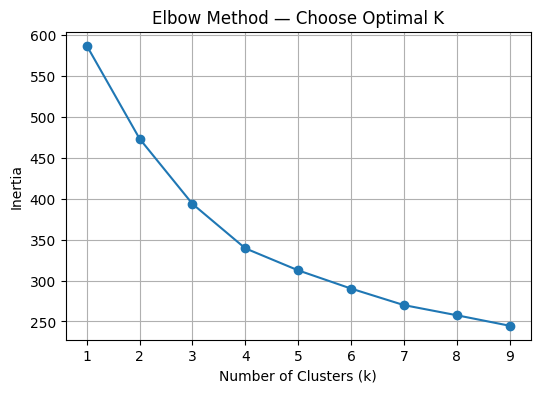


Elbow values: [587.0897333377511, 473.2882527026386, 393.6595574343588, 339.33490746593316, 312.43073008249644, 290.1473728890787, 269.9471254994816, 257.5476356725346, 244.71176206733392]


In [24]:
from sklearn.cluster import KMeans
inertia_list = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_list.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method — Choose Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()

print("\nElbow values:", inertia_list)

In [25]:
optimal_k = 5   # you can change this based on elbow curve

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

hard_labels = kmeans.labels_          # Hard cluster assignments
centroids = kmeans.cluster_centers_

In [26]:
distances = np.zeros((X_scaled.shape[0], optimal_k))

for i in range(optimal_k):
    distances[:, i] = np.linalg.norm(X_scaled - centroids[i], axis=1)

# Convert distances to fuzzy membership (small dist → high membership)
epsilon = 1e-8
inv_dist = 1 / (distances + epsilon)

fuzzy_membership = inv_dist / inv_dist.sum(axis=1, keepdims=True)

# Add results to dataframe
df["Cluster"] = hard_labels

for i in range(optimal_k):
    df[f"Membership_{i}"] = fuzzy_membership[:, i]

print("\n=== CLUSTERING COMPLETE ===")
print(df[["Cluster", "Membership_0", "Membership_1", "Membership_2"]].head())



=== CLUSTERING COMPLETE ===
   Cluster  Membership_0  Membership_1  Membership_2
0        0      0.301179      0.165658      0.180523
1        3      0.147960      0.244315      0.221942
2        2      0.137447      0.205312      0.360784
3        0      0.343491      0.145301      0.181685
4        1      0.146948      0.327649      0.177716


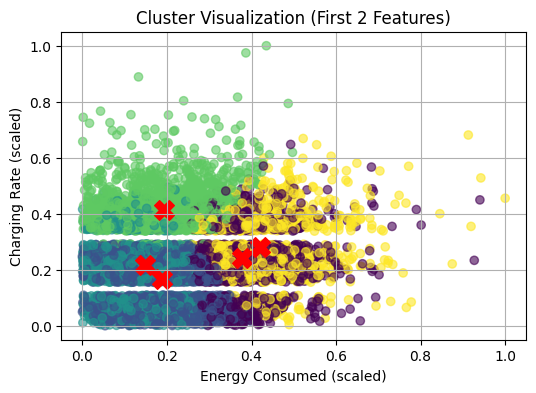

In [27]:
plt.figure(figsize=(6, 4))
plt.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=hard_labels,
    cmap="viridis",
    alpha=0.6
)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c="red",
    marker="X",
    s=200
)
plt.title("Cluster Visualization (First 2 Features)")
plt.xlabel("Energy Consumed (scaled)")
plt.ylabel("Charging Rate (scaled)")
plt.grid()
plt.show()

In [28]:
import joblib

fuzzy_config = {
    "cost_mf": {
        "low": [0, 0, 25],
        "med": [15, 30, 45],
        "high": [35, 60, 60]
    },
    "time_mf": {
        "short": [0, 0, 120],
        "med": [90, 180, 240],
        "long": [200, 330, 330]
    },
    "strategy_mf": {
        "slow": [0, 0, 1],
        "balanced": [0.5, 1, 1.5],
        "fast": [1.5, 2, 2]
    }
}

joblib.dump(fuzzy_config, 'saved_models/fuzzy_config.pkl')
print("Saved fuzzy configuration")


Saved fuzzy configuration


In [29]:

joblib.dump(kmeans, 'saved_models/kmeans_model.pkl')
joblib.dump(scaler, 'saved_models/cluster_scaler.pkl')
joblib.dump(centroids, 'saved_models/cluster_centroids.pkl')
df.to_pickle('data/clustered.pkl')
print('Saved KMeans, scaler, centroids, and clustered DataFrame')

Saved KMeans, scaler, centroids, and clustered DataFrame
